# Orbitize & Orbits for the Impatient (OFTI) #

by Isabel Angelo (2018)

OFTI (Orbits For The Impatient) is an orbit-generating algorithm designed specifically to handle data covering short fractions of long-period exoplanets [Blunt et al. 2017](https://ui.adsabs.harvard.edu/#abs/2017AJ....153..229B/abstract). Here we go through steps of using OFTI within orbitize!

In [1]:
import orbitize

## Basic Orbit Generating##

Orbits are generated in OFTI through a `Driver` class within orbitize. Once we have imported this class:

In [2]:
import orbitize.driver

we can initialize a `Driver` object specific to our data:

In [3]:
myDriver = orbitize.driver.Driver('{}/GJ504.csv'.format(orbitize.DATADIR), # path to data file
                                  'OFTI', # name of algorith for orbit-fitting
                                  1, # number of secondary bodies in system
                                  1.22, # total system mass [M_sun]
                                  56.95, # total parallax of system [mas]
                                  mass_err=0.08, # mass error [M_sun]
                                  plx_err=0.26) # parallax error [mas]

Because OFTI is an object class within orbitize, we can assign all of the OFTI attributes onto a variable (`s`). We can then generate orbits for `s` using a function called `run_sampler`, a method of the `OFTI` class. The `run_sampler` method takes in the desired number of accepted orbits as an input.

Here we use run OFTI to randomly generate orbits until 1000 are accepted:

In [4]:
s = myDriver.sampler
orbits = s.run_sampler(1000)

We have now generated 1000 possible orbits for our system. Here, `orbits` is a (100 x 8) array, where each of the 100 elements corresponds to a single orbit. An orbit is represented by 8 orbital elements. 

Here is an example of what an accepted orbit looks like from orbitize:

In [ ]:
orbits[0]

To further inspect what each of the 8 elements in your orbit represents, you can view the system.param_idx variable. This is a dictionary that tells you the indices  of your orbit that correspond to a particular orbit's semi-major axis (a), eccentricity (e), inclination (i), arguement of periastron (aop), position angle of nodes (pan), and epoch of periastron passage (epp). The last two indices are the parallax and system mass, and the number following the parameter name indicates the number of the body in the system.

In [ ]:
s.system.param_idx

## Plotting ##

Now that we have generated possible orbits for our system, we want to be able to plot our output orbits in ways that allow us to interpret our results. Here we will go through a brief overview on ways to visualize your data within orbitize. For a more detailed guide on data visualization capabilities within orbitize, see the [Orbitize plotting tutorial](*insert plotting tutorial link*).

### Histogram ###

One way to visualize our results is through histograms of our computed orbital parameters. Our orbits are output from `run_sampler` as an array of orbits, where each orbit is represented by a set of orbital elements:

In [ ]:
print(orbits.shape)
orbits[:5]

We can effectivly view outputs from `run_sampler` by creating a histogram of a given orbit element to see its distribution of possible values. Our system.param_idx dictionary is useful here. We can use it to determine the index of a given orbit that corresponds to the orbital element we are interested in:

In [ ]:
s.system.param_idx

If we want to plot the distribution of orbital semi-major axes ($a$) in our generated orbits, we would use the index dictionary `s.system.param_idx` to index the semi-major axis element from each orbit:

In [ ]:
sma = [x[s.system.param_idx['sma1']] for x in orbits]

%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(sma, bins=30)
plt.xlabel('orbital semi-major axis [AU]')
plt.ylabel('occurence')
plt.show()

You can use this method to create histograms of any orbital element you are interested in:

In [ ]:
ecc = [x[s.system.param_idx['ecc1']] for x in orbits]
i = [x[s.system.param_idx['inc1']] for x in orbits]

plt.figure(figsize=(10,3))
plt.subplot(131)
plt.hist(sma, bins=30)
plt.xlabel('orbital semi-major axis [AU]')
plt.ylabel('occurence')

plt.subplot(132)
plt.hist(ecc, bins=30)
plt.xlabel('eccentricity [0,1]')
plt.ylabel('occurence')

plt.subplot(133)
plt.hist(i, bins=30)
plt.xlabel('inclination angle [rad]')
plt.ylabel('occurence')

plt.show()

In addition to our `orbits` array, Orbitize also creates a `Results` class that contains built-in plotting capabilities for two types of plots: corner plots and orbit plots.  

### Corner Plot ###

To make plots using the results class, we first import the results class and intialize a `Results` object. The orbit-fitting algorithm (OFTI or MCMC) must be input along with the orbits array generated in the orbit-fitting process:

In [5]:
import orbitize.results
myResults = orbitize.results.Results('OFTI',orbits)

We can now create a corner plot using the function `plot_corner` within the `Results` class. This function requires an input list of the parameters, in string format, that you wish to include in your corner plot. We can even plot all of the orbital parameters at once! As shown below:

In [ ]:
corner_figure = myResults.plot_corner(param_list=['sma1', 'ecc1', 'inc1', 'aop1', 'pan1','epp1'])

### Orbit Plot ###

What about if we want to see how the orbits look in the sky? Don't worry, the `Results` class has a command for that too! It's called `plot_orbits`. We can create a simple orbit plot by running the command as follows:

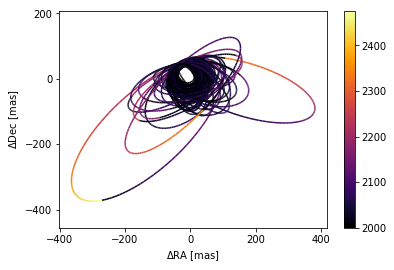

In [6]:
orbit_figure = myResults.plot_orbits()

Here, the colorbar represents the year at which the object will pass the corresponding location in its orbit.

## Advanced OFTI and API Interaction ##

We've seen how the `run_sampler` command is the fastest way to generate orbits within OFTI. For users interested in what's going on under-the-hood, this part of the tutorial takes us through each step of `run_sampler`. Understanding the intermediate stages of orbit-fitting can allow for more customization that goes beyond Orbitize's default parameters.

We begin again by intializing a `sampler` object on which we can run OFTI:

In [ ]:
myDriver = orbitize.driver.Driver('{}/GJ504.csv'.format(orbitize.DATADIR), # path to data file
                                  'OFTI', # name of algorith for orbit-fitting
                                  1, # number of secondary bodies in system
                                  1.22, # total system mass [M_sun]
                                  56.95, # total parallax of system [mas]
                                  mass_err=0.08, # mass error [M_sun]
                                  plx_err=0.26) # parallax error [mas]

In [ ]:
s = myDriver.sampler

In orbitize, the first thing that OFTI does is prepare an initial set of possible orbits for our object through a function called `prepare_samples`, which takes in the number of orbits to generate as an input. For example, we can generate 10,000 orbits as follows:

In [ ]:
samples = s.prepare_samples(10000)

Here, `samples` is an array of randomly generated orbits that have been scaled-and-rotated to fit our astrometric observations. The first and second dimension of this array are the number of orbital elements and total orbits generated, respectively. In other words, each element in `samples` represents the value of a particular orbital element for each generated orbit:

In [ ]:
print('samples: ', samples.shape)
print('first element of samples: ', samples[0].shape)

Once our initial set of orbits is generated, they are vetted for likelihood in a function called `reject`. This function computes the probability of an orbit based on it's associated chi squared. It then rejects orbits with lower likelihoods and accepts the orbits that are more probable. The output of this function is an array of possible orbits for our input system.

In [ ]:
orbits, lnlikes = s.reject(samples)

Our `orbits` array represents the final orbits that are output by OFTI. The number of elements in this array represents the number of intially generated orbits that was accepted in the `reject` step. This number can vary each time `reject` is run because the orbits are intially randomly generated. 

Each element in our orbits array contains the 8 orbital elements that are computed by orbitize:

In [ ]:
orbits.shape

We can synthesize this sequence with the `run_sampler()` command, which runs through the steps above until the input number of orbits has been accepted. Additionally, we can specify the number of orbits generated by `prepare_samples` each time the sequence is intiated with an argument called `num_samples`. Higher values for `num_samples` will output more accepted orbits, but may take longer to run since all initially prepared orbits will be run through the rejection step.

For example, we can prepare sets 1,000 samples at a time and run them through rejection sampling until a total of 100 orbits are accepted with the following command:

In [ ]:
orbits = s.run_sampler(100, num_samples=1000)

## Saving and Loading Results ##

Finally, we can save our generated orbits in a file that can be easily read for future use and analysis. Here we will walk through the steps of saving a set of orbits to a file in hdf5 format. To see how to save results in .fits format, see the Orbitize MCMC tutorial [here](https://orbitize.readthedocs.io/en/docs_devel/tutorials/MCMC_tutorial.html).

The first step is to import h5py and create a file that you wish to store your data in. Here, the `'w'` in this command indicates that we are **w**riting the file.

In [ ]:
import h5py
f = h5py.File('orbits.hdf5', 'w')

Next we want to store the data (in our case, the `orbits` array generated by OFTI above) in a dataset within the file we've created:

In [ ]:
f.create_dataset('orbits', data=orbits)
f.close()

Once you are done writing data to your file, closing the file will end any processes involved in opening and writing the file. Now when you are ready to use your orbits data, it is easily accessible through the file we've created:

In [ ]:
f = h5py.File('orbits.hdf5', 'r')
orbits = f['orbits']

print('orbits array dimensions: ', orbits.shape)
print('orbital elements for first orbit: ', orbits[0])

f.close()

And now we can easily work with the saved orbits that were generated by Orbitize! Find out more about generating orbits in Orbitize with tutorials available [here](https://orbitize.readthedocs.io/en/docs_devel/tutorials.html).